# F1 Calendar

When it comes to the environmental impact of Formula 1, the emissions attributed to the racing is tiny compared to the logistical circus that comes with it - [source](https://www.thinkingsustainably.com/f1-raceing-for-the-environment/#2--transporting-vehicles-is-incredibly-difficult-).

Transportation to the circuits contributes to around 45% of Formula 1 emissions. With 23 Grand Prixes on the calendar for 2023, and 20 countries to visit in 5 continents, we can see why.
But one decision that has a massive impact in the emissions from transportation is the order of which the races are scheduled.
The current schedule has us crossing the Atlantic Ocean 6 times (equal to the number of races in the Americas) including a ridiculus non-stop trip from Las Vegas to Abu Dhabi. In short, it is a completely unoptimised mess.
So I thought I'd see if I can use graph theory to reduce the total distance travelled, and therefore reduce the emissions.

In [1]:
import requests
import pandas as pd
import numpy as np


import networkx as nx
import geopy

from f_wikipedia import get_calendar, circuit_to_coordinates
from f_graph import df_to_graph, graph_to_distances, total_graph_distance



## Get data

I'm using the race calendar from the [2023 World Championship Wikipedia page](https://en.wikipedia.org/wiki/2023_Formula_One_World_Championship) to create a graphical representation of the 23 circuits.

To do this, I will also need to find the locations of each of the circuits.
I'll do this by looking at the infobox (the box on the right hand side of each wikipedia page) for each circuit, and adding the coordinate to the dataframe.


In [2]:
races = get_calendar()
races["Coordinates"] = [(0,0) for _ in races.index]

for i, x in races.iterrows():
    races.loc[i, "Coordinates"] = circuit_to_coordinates(x["Circuit"])

In [3]:
races.head()

,Round,Grand Prix,Circuit,Race date,Coordinates
0,1,Bahrain Grand Prix,"Bahrain International Circuit, Sakhir",5 March,"(26.0325, 50.51056)"
1,2,Saudi Arabian Grand Prix,"Jeddah Corniche Circuit, Jeddah",19 March,"(21.63194, 39.10444)"
2,3,Australian Grand Prix,"Albert Park Circuit, Melbourne",2 April,"(-37.84972, 144.96833)"
3,4,Azerbaijan Grand Prix,"Baku City Circuit, Baku",30 April,"(40.3725, 49.85333)"
4,5,Miami Grand Prix,"Miami International Autodrome, Miami Gardens, ...",7 May,"(25.95806, -80.23889)"


## Create graph

Now that we have a list of the circuits and their locations, we have everything we need to be able to able to represent the dataset in a graph.
First, let's add each circuit as a node.
Then, add each of the trips between circuits as the edges.
We can calculate the distance between the circuits and add this as an edge attribute.

Total distance travelled in original calendar: 132254.59 km


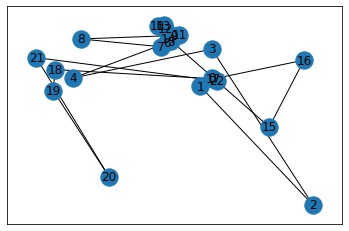

In [4]:
# create calendar graph
G_calendar, pos = df_to_graph(races, "Round")
total_dist_calendar_km = total_graph_distance(G_calendar)
print(f"Total distance travelled in original calendar: {total_dist_calendar_km:.2f} km")
nx.draw_networkx(G_calendar, pos=pos)

Just from looking at the graph, we can see that there are several long trips that are being made unnecessarily.
This can definitely be improved upon.

## Preparing for optimisation

To enable us to find the optimal path through all the circuits, we need to create a fully connected network and find the distances between all circuit pairs.

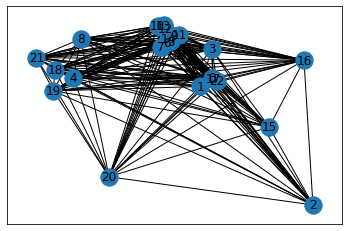

In [5]:
G_full, _ = df_to_graph(races)
nx.draw_networkx(G_full, pos=pos)


## Travelling Salesperson

This optimisation problem is known commonly as the travelling salesperson problem and [can be optimised using the `mlrose` module in python](https://towardsdatascience.com/solving-travelling-salesperson-problems-with-python-5de7e883d847).

The module is expecting a list where each item is a tuple `(u, v, d)` where `u` is the 'from' node, `v` is the 'to' node, and `d` is the distance between `u` and `v`.
So once we convert our graph into this format, we can pass it into the fitness function.

The algorithm will then attempt to create a route visiting each node once (and only once) while minimising the distance travelled.

This is a complicated problem state with a huge number ($23! \approx 2.5 \times 10^{22}$) of potential solutions to optimise, so the algorithm will be nondeterminate and will  be improved by a good selection of hyperparameters.


In [6]:
import networkx as nx
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose


# convert graph for fitness function
distances = graph_to_distances(G_full)
length = races.shape[0]

# optimise graph
#TODO: remove return back to start 
fitness_dists = mlrose.TravellingSales(distances=distances)
problem_fit = mlrose.TSPOpt(length=length, fitness_fn=fitness_dists, maximize=False)
best_solution, best_fitness = mlrose.genetic_alg(problem_fit, random_state = 2, max_attempts=40, mutation_prob=0.25)

print(f"The best state found is: {best_solution}")
print(f"The distance of the best solution is: {best_fitness:.2f}km")

races.loc[best_solution, "optimal_round"] = range(length)

The best state found is: [ 5  9  8 20  6 13  7 14 22 16  4 21 19 18 10 11 12  1 17  0 15  2  3]
The distance of the best solution is: 103642.99km


## Optimised Solution

One thing to note, is that this version of the model is optimising for a round tour, so the distance between the last circuit back round to the first circuit has also been optimised for.
This is something that I will look at in the future.


This model gives us a much better order to run the races, and as a result, the total distance travelled has been reduced from 132254.59km down to 100498.85km.
This is a massive decrease of 24%!

Formula 1 claims that its annual emissions were around [250,000 tonnes of CO2](https://www.autosport.com/f1/news/f1-announces-plan-to-offset-256551-tonne-carbon-footprint-4985867/4985867/) for the 2019 season.
Therefore, the amount attributed to logistics in 2019 was ~115,000 tonnes (using the 45% figure from earlier).
Although that figure has almost certainly increased from 2019, it is a reasonable estimate for 2023. 
If we were to use the optimised model to decrease our travel by 24%, we could therefore estimate that this model would reduce the carbon emissions by over 27,000 tonnes.


We can also see, visually, that this a much better solution as the number of long-haul journies has been reduced significantly.
There's still a lot of scope for improvement, though.
A keen data scientist could definitely tune the hyperparameters better than I have to find a better result, but I'm pretty happy nonetheless.


Liberty Media, I'm sure you are reading. Feel free to contact me at james@robinson.fyi.

Total distance travelled in original calendar: 100498.85 km
Total distance including return to start point: 103642.99 km
Estimated CO2 emissions saved: 27720.29


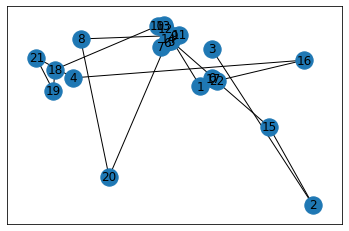

In [9]:
# create optimised graph
G_optimised, _ = df_to_graph(races, "optimal_round")
total_dist_optimal_km = total_graph_distance(G_optimised)
annual_emissions_logistics_tCO2 = 256_551 * 0.45
proportion_of_travel = total_dist_optimal_km / total_dist_calendar_km
print(f"Total distance travelled in original calendar: {total_dist_optimal_km:.2f} km")
print(f"Total distance including return to start point: {total_dist_optimal_km + G_full.edges()[(3,5)]['dist_km']:.2f} km")
print(f"Estimated CO2 emissions saved: {(1-proportion_of_travel) * annual_emissions_logistics_tCO2:.2f} tCO2")
nx.draw_networkx(G_optimised, pos=pos)